In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both 1day and SPY 1day Adjusted Close Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error

# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_3

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  1995-01-03   1.228913   25967200
1     1  1995-01-04   1.260937   39670400
2     2  1995-01-05   1.244925   18410000
3     3  1995-01-06   1.344999  269155600
4     4  1995-01-09   1.319479   68521600
---
      Item        Date   Adj_Close    Volume
5147  5147  2015-06-12  122.781413  36886200
5148  5148  2015-06-15  122.540040  43988900
5149  5149  2015-06-16  123.196574  31494100
5150  5150  2015-06-17  122.906931  32918100
5151  5151  2015-06-18  123.466910  35407200


In [4]:
#Request SPY Stock Data
spy_data = Share(tick_0)
spy_historical = spy_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
spy_item = []
spy_date = []
spy_close = []
spy_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(spy_historical)-1,-1,-1):
    d = spy_historical[i]
    spy_item.append(i_counter)
    spy_date.append(d['Date'])
    spy_close.append(d['Adj_Close'])
    spy_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
spy_df = pd.DataFrame()
    
#Add factors to dataframe
spy_df['Item'] = spy_item
spy_df['Date'] = spy_date
spy_df['Adj_Close'] = pd.to_numeric(spy_close)
spy_df['Volume'] = pd.to_numeric(spy_volume)

#Print the dataframe head and tail
print(spy_df.head())
print("---")
print(spy_df.tail())

   Item        Date  Adj_Close  Volume
0     0  1995-01-03  30.574097  324300
1     1  1995-01-04  30.720218  351800
2     2  1995-01-05  30.720218   89800
3     3  1995-01-06  30.751472  448400
4     4  1995-01-09  30.782794   36800
---
      Item        Date   Adj_Close     Volume
5147  5147  2015-06-12  201.460969  135382400
5148  5148  2015-06-15  200.597612  124384200
5149  5149  2015-06-16  201.691205   85308200
5150  5150  2015-06-17  202.017360  126708600
5151  5151  2015-06-18  204.118213  165867900


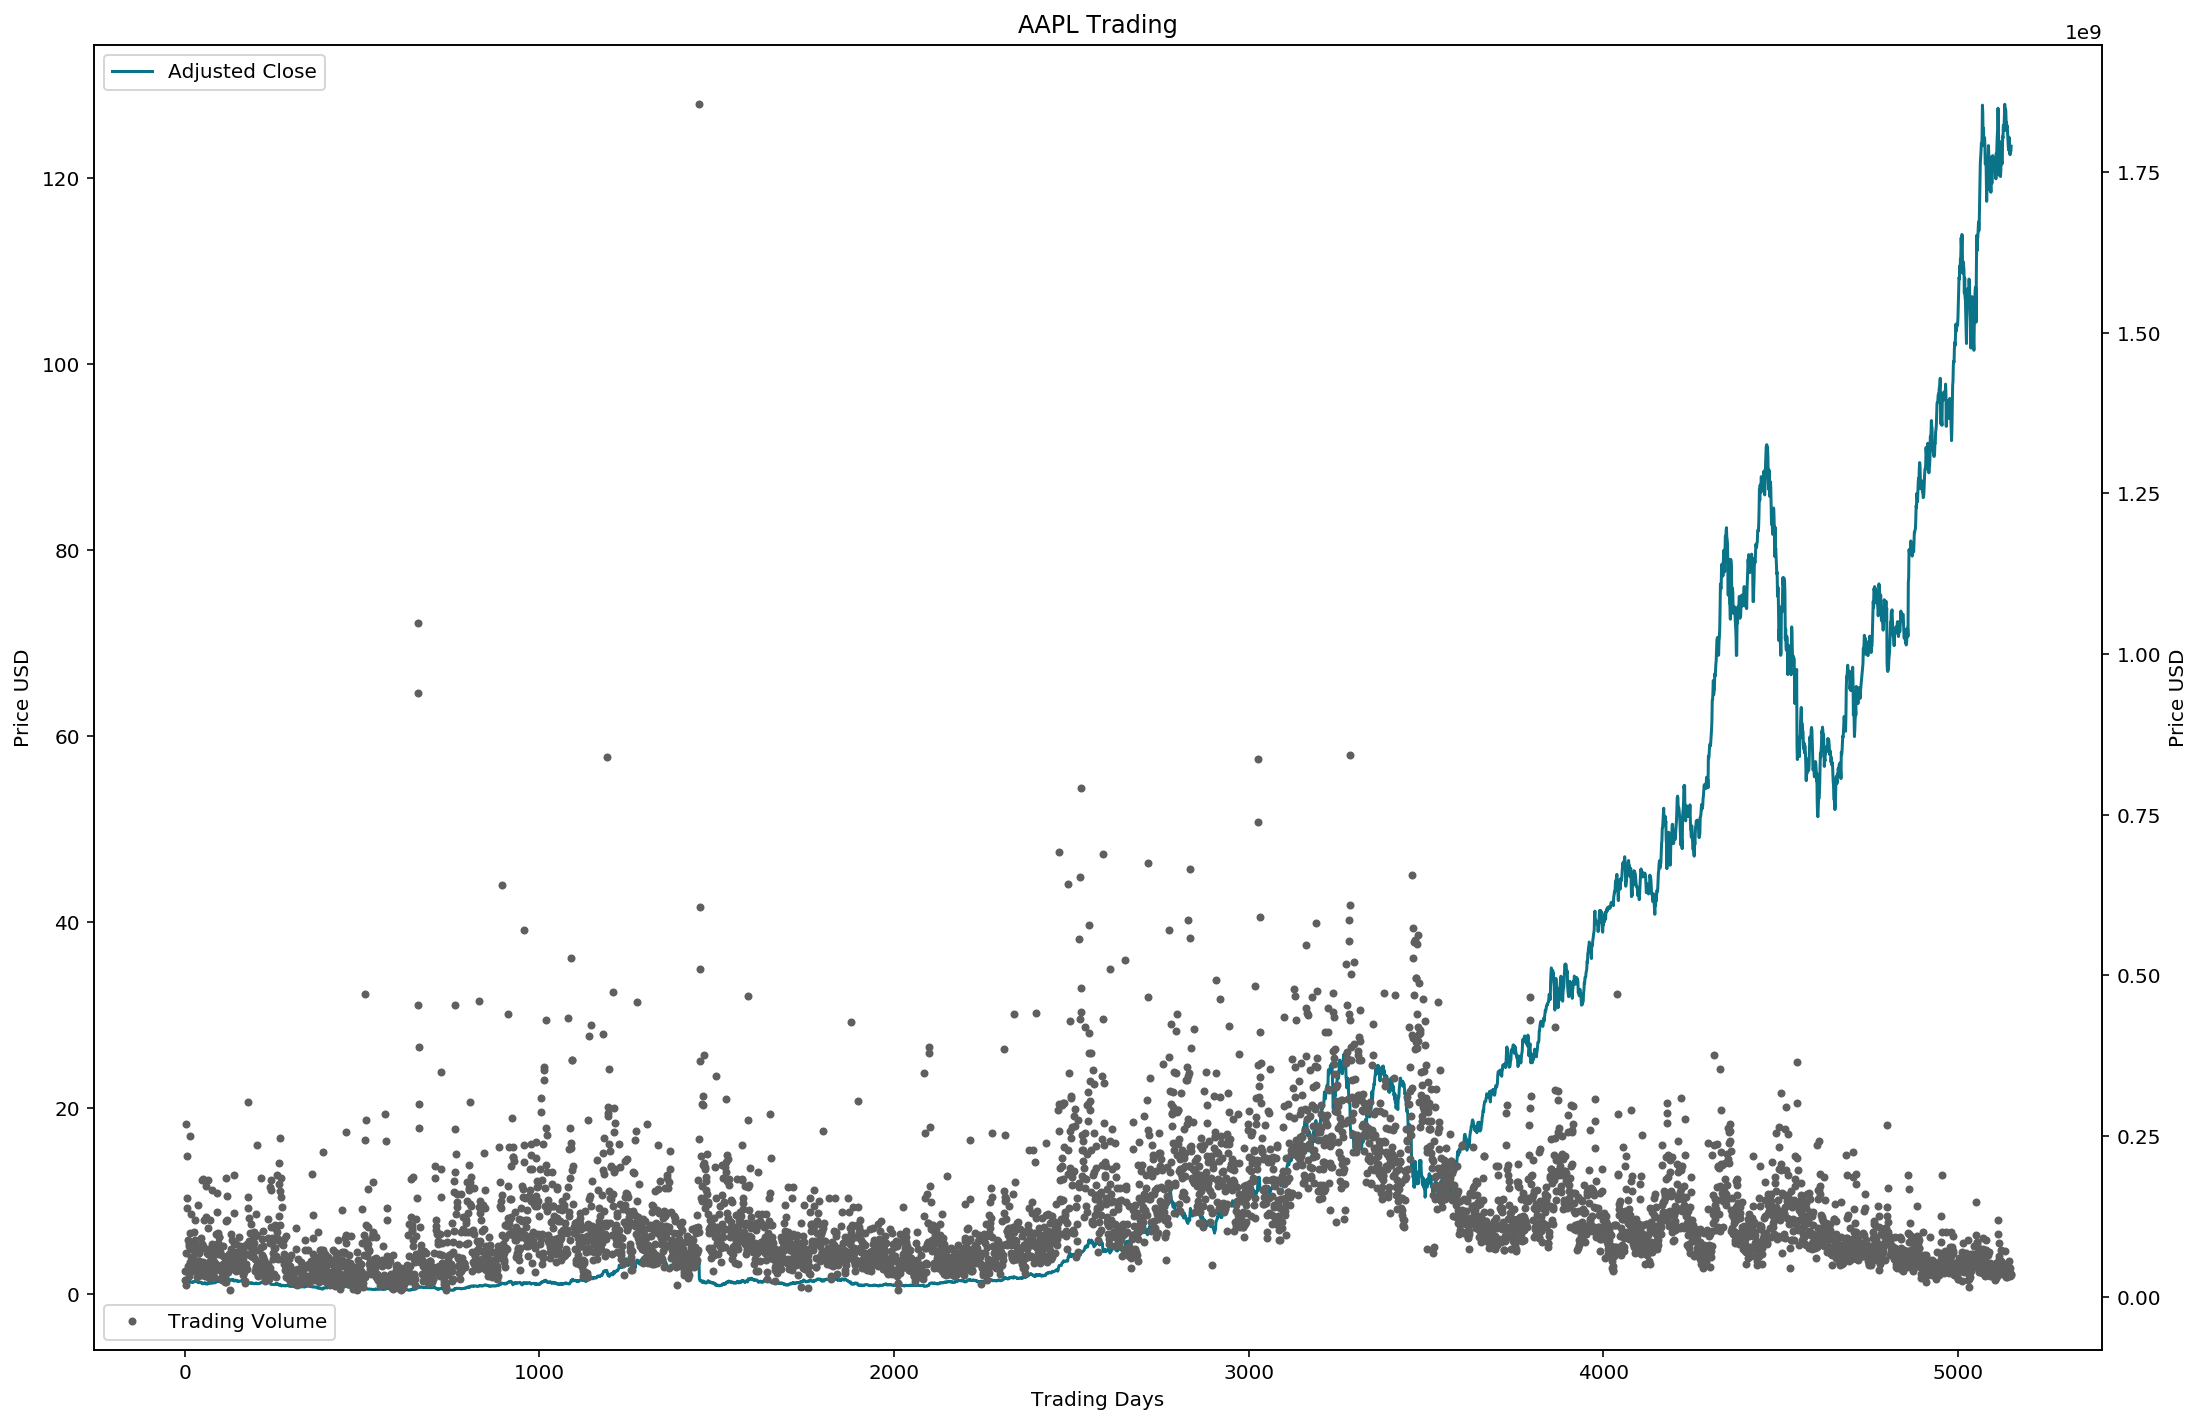

In [5]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [6]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append([(row['Item'])])
    vol_all.append([(row['Volume'])])
    close_all.append([(row['Adj_Close'])])

#Create numpy arrays for features and targets
spy_day_all = []
spy_vol_all = []
spy_close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in spy_df.iterrows():
    #print([np.array(row['Item'])])
    spy_day_all.append([(row['Item'])])
    spy_vol_all.append([(row['Volume'])])
    spy_close_all.append([(row['Adj_Close'])])

pprint(close_all)

[[1.228913],
 [1.260937],
 [1.244925],
 [1.344999],
 [1.319479],
 [1.399039],
 [1.497112],
 [1.45308],
 [1.437068],
 [1.425059],
 [1.441071],
 [1.461085],
 [1.469091],
 [1.365014],
 [1.353005],
 [1.33299],
 [1.312473],
 [1.26494],
 [1.276949],
 [1.2849549999999998],
 [1.292961],
 [1.2849549999999998],
 [1.33299],
 [1.296964],
 [1.296964],
 [1.3069709999999999],
 [1.355007],
 [1.397038],
 [1.401041],
 [1.404898],
 [1.378807],
 [1.366765],
 [1.386835],
 [1.364758],
 [1.31659],
 [1.310569],
 [1.290499],
 [1.252366],
 [1.2282819999999999],
 [1.268422],
 [1.284478],
 [1.284478],
 [1.292506],
 [1.27645],
 [1.230289],
 [1.270429],
 [1.27645],
 [1.268422],
 [1.2242680000000001],
 [1.1239190000000001],
 [1.1239190000000001],
 [1.131946],
 [1.127932],
 [1.131946],
 [1.164058],
 [1.222261],
 [1.192156],
 [1.212226],
 [1.1941629999999999],
 [1.103849],
 [1.103849],
 [1.13596],
 [1.131946],
 [1.139975],
 [1.087793],
 [1.115891],
 [1.1801139999999999],
 [1.1801139999999999],
 [1.1761],
 [1.212226],


In [7]:
# Reshape into t and t+1
look_back = 1 
tt_split = (1.0-.315)

X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)
X_spy_close_train, y_spy_close_train, X_spy_close_test, y_spy_close_test, spy_close_bounds = \
    util.create_dataset(spy_close_all, look_back, tt_split, True)
    
pprint(X_close_train)
print('--')
pprint(X_spy_close_train)

array([[[ 0.00634957]],

       [[ 0.00660065]],

       [[ 0.00647511]],

       ..., 
       [[ 0.08341128]],

       [[ 0.08889649]],

       [[ 0.09278693]]])
--
array([[[ 0.        ]],

       [[ 0.00083864]],

       [[ 0.00083864]],

       ..., 
       [[ 0.26131066]],

       [[ 0.27447623]],

       [[ 0.2739438 ]]])


In [8]:
pprint(np.shape(X_close_train))
pprint(np.shape(X_spy_close_train))

pprint(X_close_train)

pprint(y_close_train)

(3528, 1, 1)
(3528, 1, 1)
array([[[ 0.00634957]],

       [[ 0.00660065]],

       [[ 0.00647511]],

       ..., 
       [[ 0.08341128]],

       [[ 0.08889649]],

       [[ 0.09278693]]])
array([[ 0.00634957],
       [ 0.00660065],
       [ 0.00647511],
       ..., 
       [ 0.08341128],
       [ 0.08889649],
       [ 0.09278693]])


In [9]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [16,32]

# Create two branches of LSTM model

# Create LSTM Adjusted Close network - 1 day tracker 
model_a = Sequential()
model_a.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model_a.add(Dense(1))
model_a.add(Activation('linear'))

# Create LSTM Adjusted Close network - 1 day tracker for SPY (macro market trends)
model_b = Sequential()
model_b.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model_b.add(Dense(1))
model_b.add(Activation('linear'))

# Create Merged Model
merged_model = Merge([model_a, model_b], mode='sum', concat_axis=1)

# Create final composite model
final_model = Sequential()
final_model.add(merged_model)
# Potential add layers
final_model.add(Dense(1))
# Activation layer?

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.112269878387


In [10]:
# Format inputs
train_inputs = [X_close_train, X_spy_close_train]

# Train the model
final_model.fit(train_inputs, 
                y_close_train, 
                nb_epoch=epochs, 
                batch_size=batch_size, 
                verbose=2,
                validation_split=0.05)

Train on 3351 samples, validate on 177 samples
Epoch 1/1
19s - loss: 2.3707e-04 - val_loss: 1.0072e-06


In [11]:
# Format inputs
test_inputs = [X_close_test, X_spy_close_test]

# Generate predictions for training
testPredict = final_model.predict(test_inputs, batch_size=batch_size)
#testPredict = util.predict_sequences(final_model, test_inputs)
pprint(testPredict)

array([[ 0.08976825],
       [ 0.08771107],
       [ 0.08942987],
       ..., 
       [ 1.04911339],
       [ 1.04696167],
       [ 1.05277312]], dtype=float32)


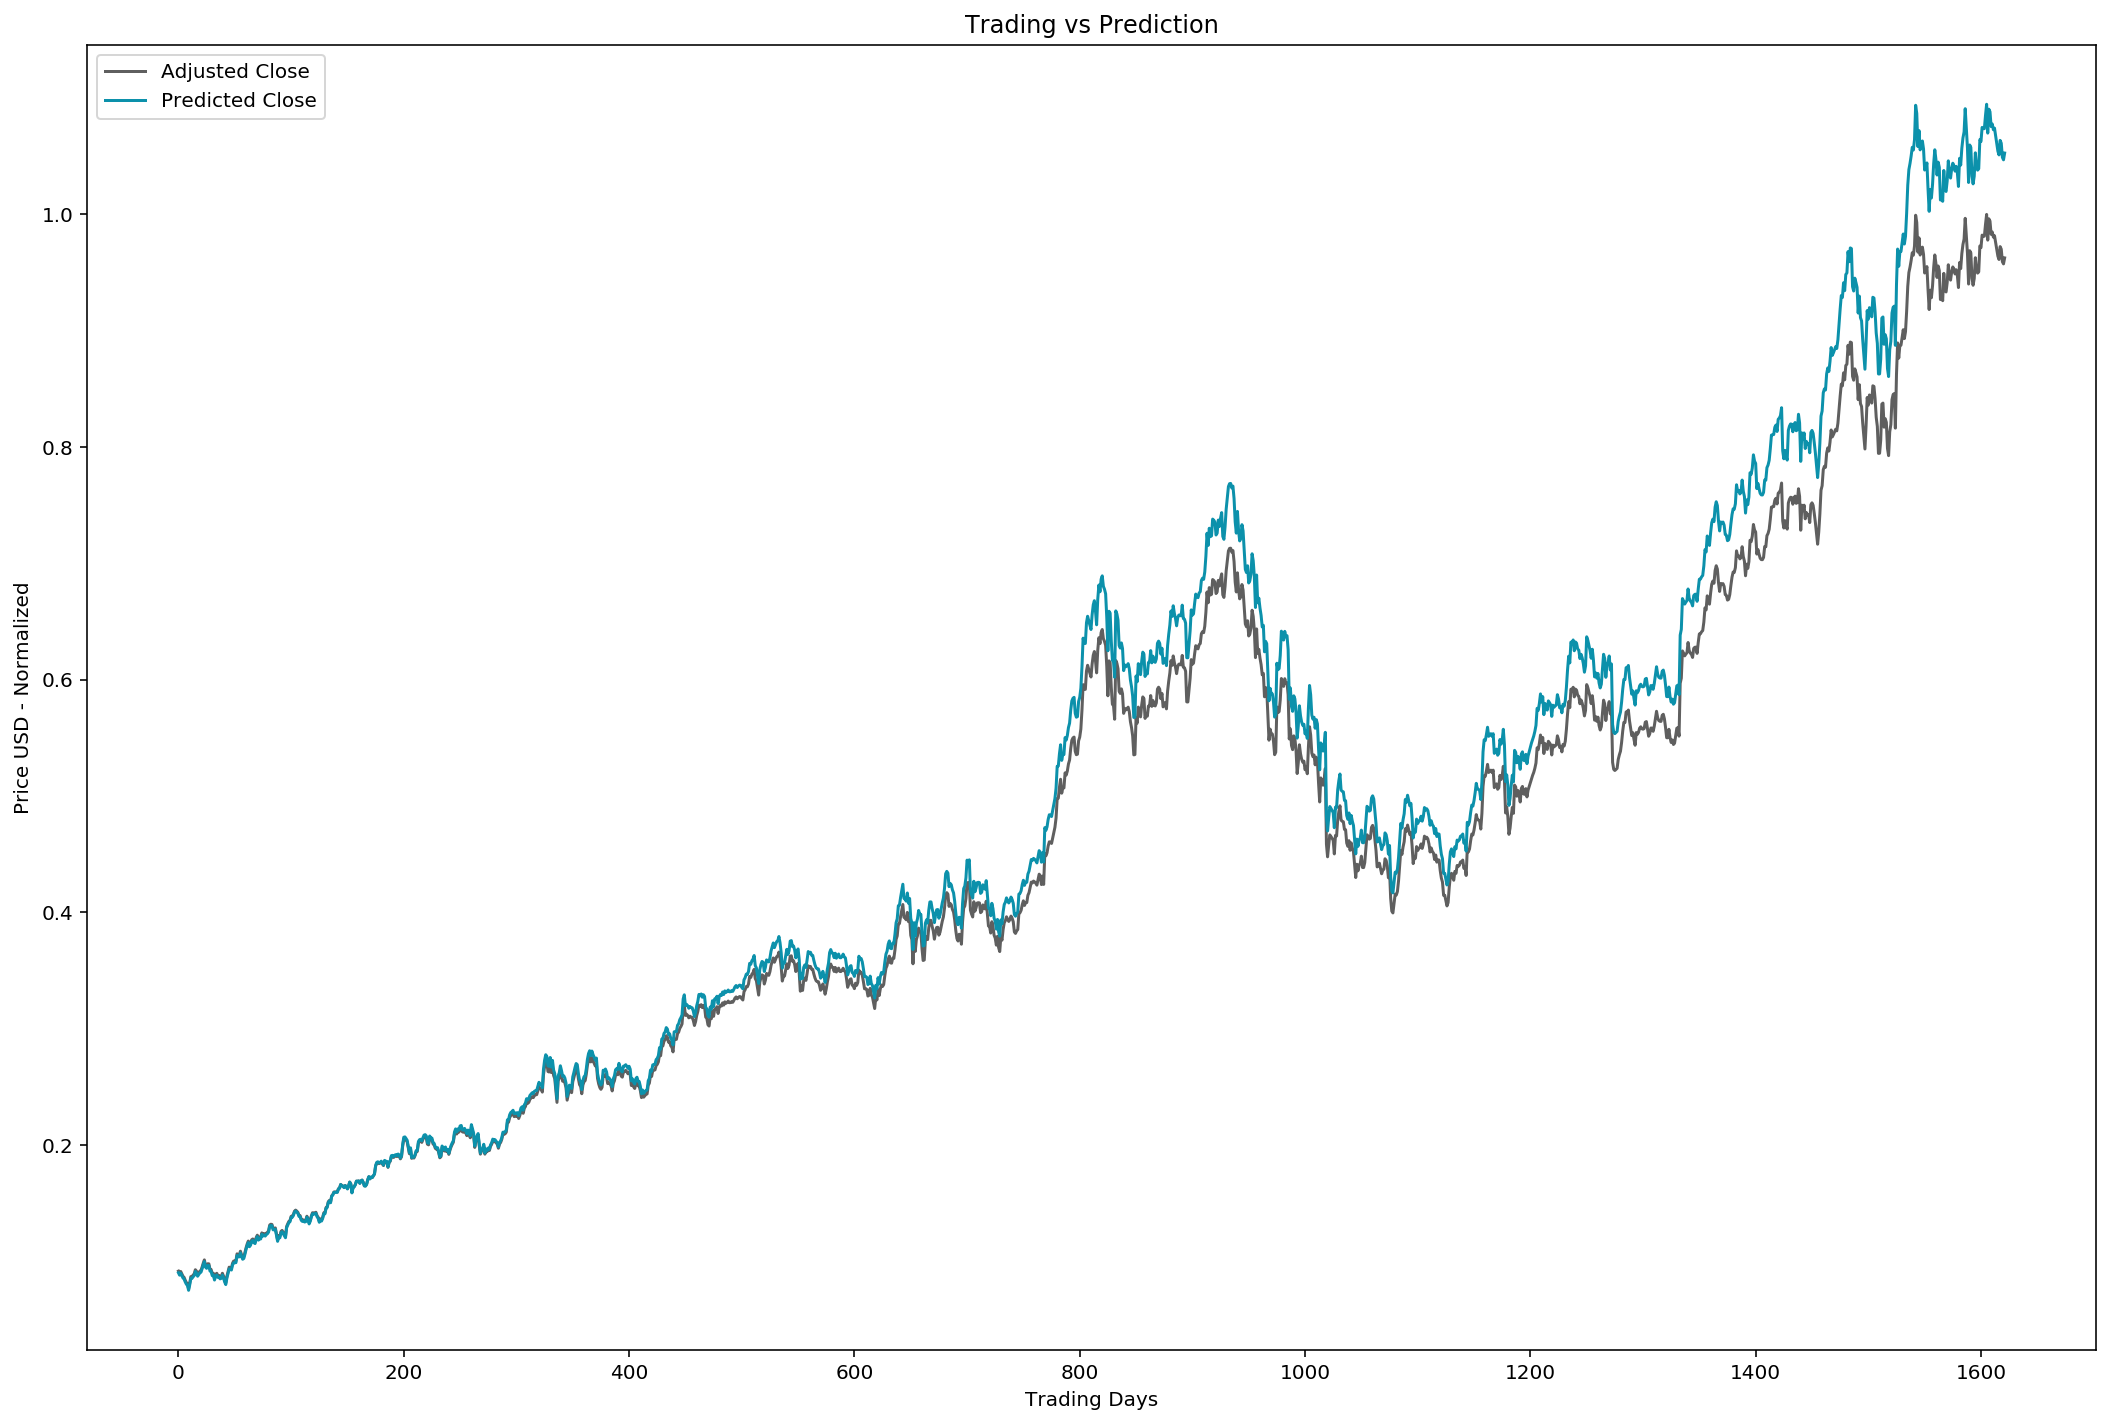

In [12]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [13]:
# The mean squared error
testScore = final_model.evaluate(test_inputs, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.001395 MSE (0.037350 RMSE)


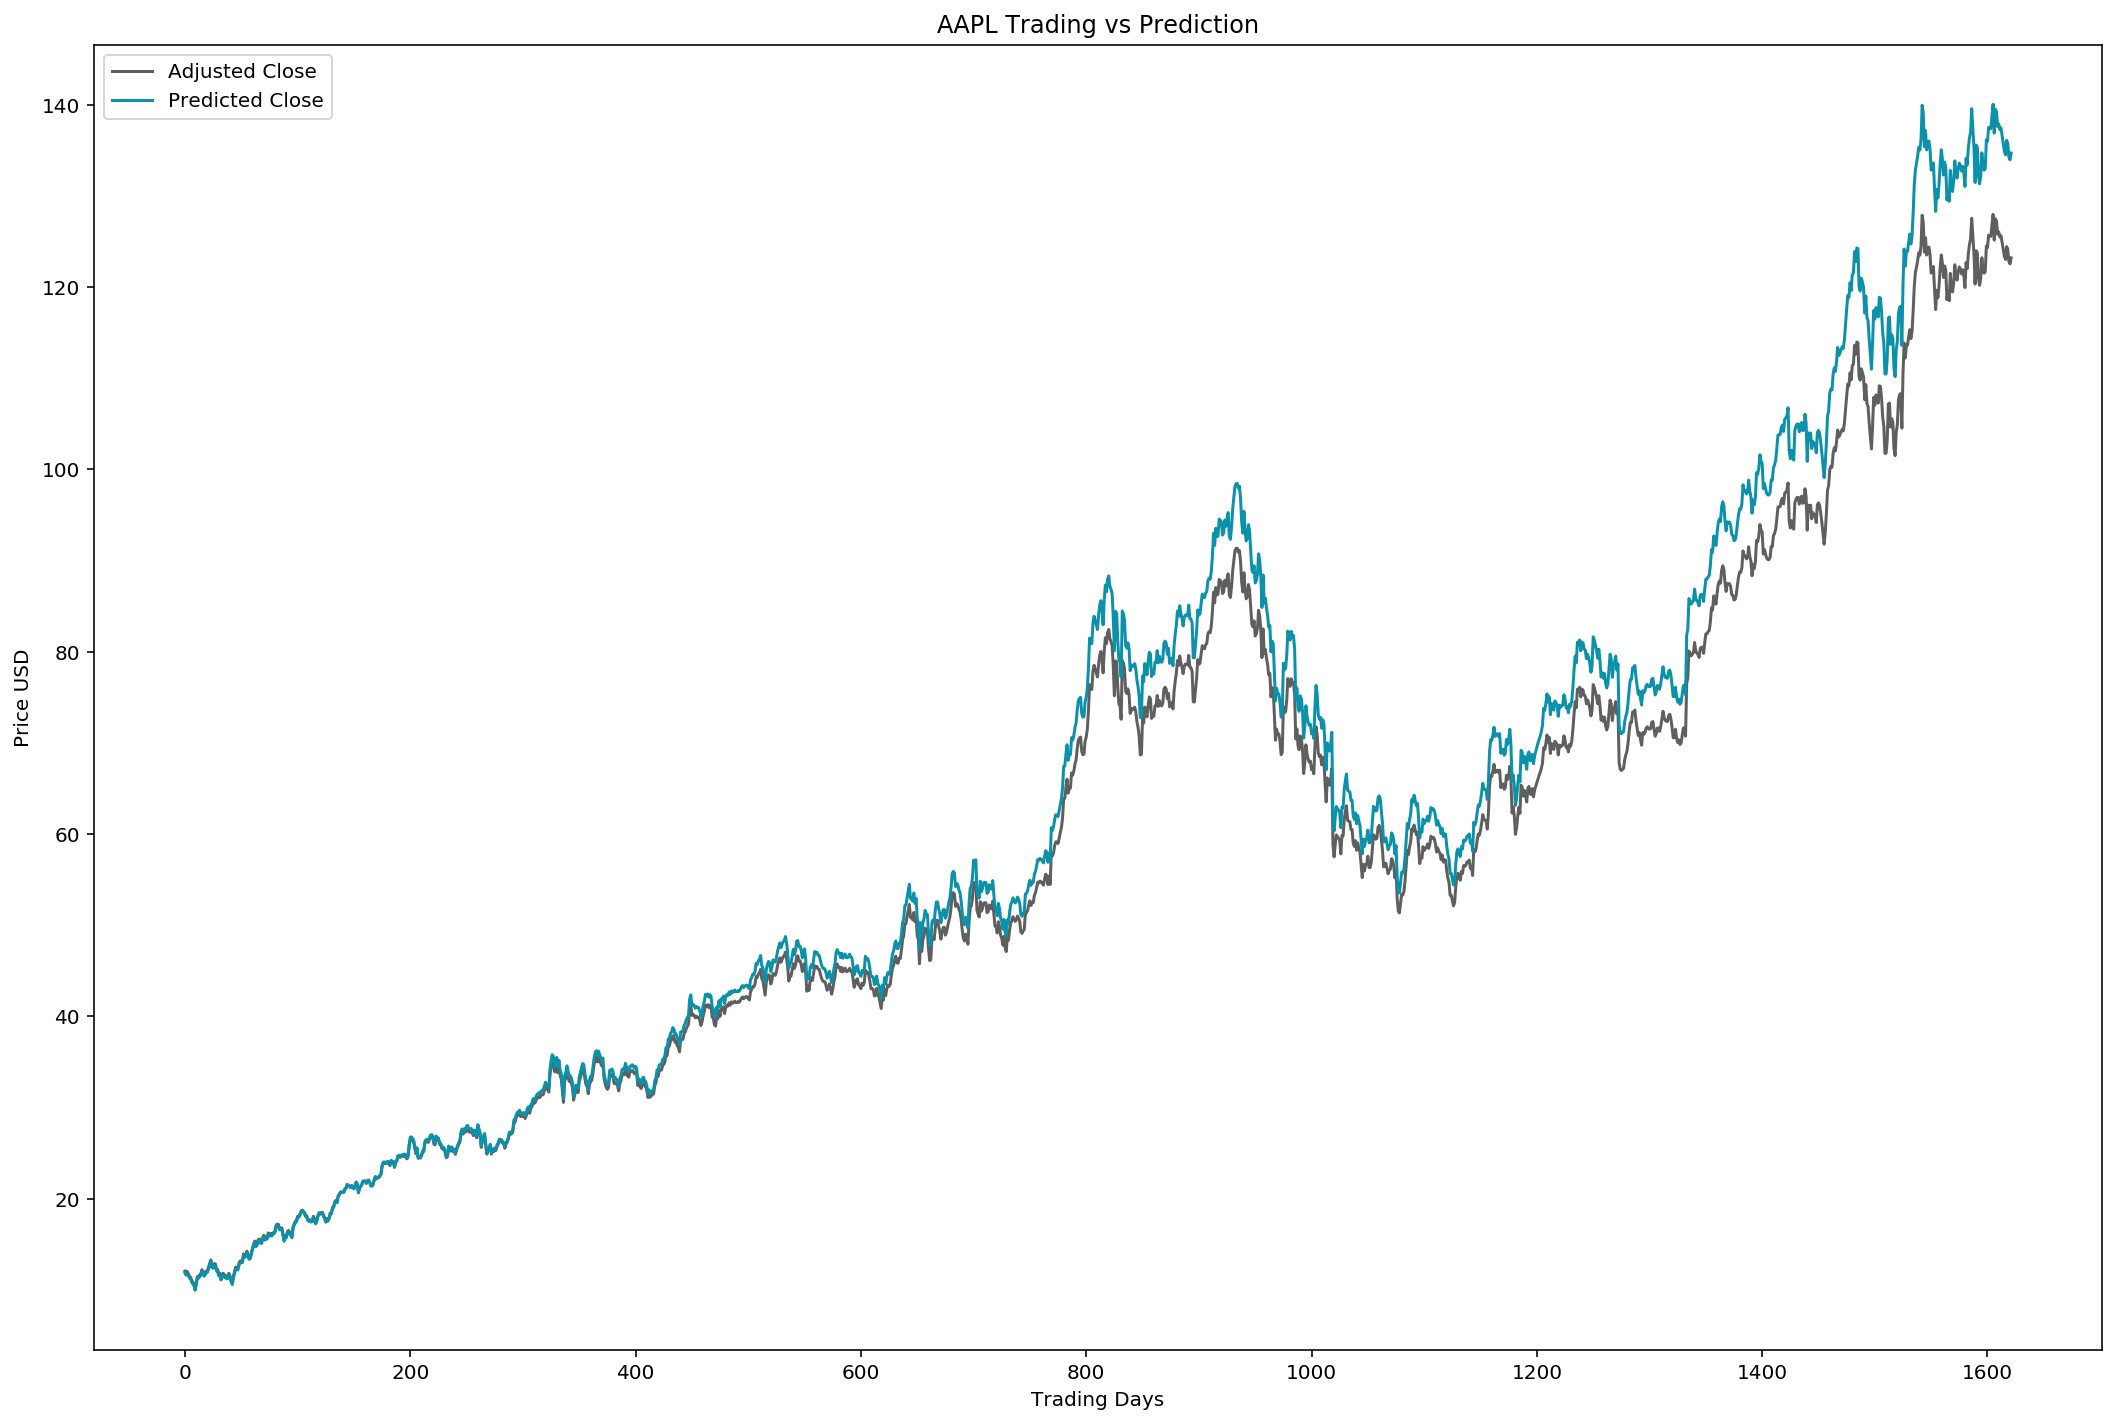

In [14]:
# Plot the predictions
#close_plot = close_all[-ya_close_test.shape[0]:]

close_seq = np.array(y_close_test)
pred_seq = np.array(testPredict)

#pprint(pred_seq)
close_seq_plot, r = util.scale_range(y_close_test, input_range=[0.0,1.0], target_range=close_bounds)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_seq_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

# Log of Results:
Epochs: 1 

### SPY [AdjClose(1)+SPY(1)]
Test Score: 0.000018 MSE (0.004271 RMSE)

### GE [AdjClose(1)+SPY(1)]
Test Score: 0.00116 MSE (0.03407 RMSE)

### MSFT [AdjClose(1)+SPY(1)]
Test Score: 0.000031 MSE (0.005605 RMSE)

### AAPL [AdjClose(1)+SPY(1)]
Test Score: 0.001395 MSE (0.037350 RMSE)